In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc
from scipy.spatial.distance import euclidean
import os
import sounddevice as sd

In [24]:


def get_wav_files(folder_path):
    """
    Lấy danh sách các tệp WAV trong thư mục và các thư mục con.
    """
    wav_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".wav"):
                wav_files.append(os.path.join(root, file))
    return wav_files

def calc_mel_cep_standard(file_path, index_of_mel_cep, num_of_coef):
    """
    Tính toán mel-cepstrum cho một tệp WAV bằng cách sử dụng phân biệt giọng nói.
    """
    base_ste, threshold, silence_index_array, frame_length, frame_total = speech_discrimination(file_path)
    rate, signal = wavfile.read(file_path)

    start_index, end_index = find_stable(silence_index_array, frame_length, frame_total)

    # Calculate mel-cepstrum
    c = mfcc(signal[start_index:end_index], rate, numcep=num_of_coef, nfilt=26, winlen=0.03, winstep=0.015)
    vector_average = np.mean(c, axis=0)

    return vector_average

def detect_vowel(mel_cep, mel_cep_average, num_of_coef):
    """
    Phát hiện nguyên âm dựa trên khoảng cách Euclidean giữa các vector mel-cepstrum.
    """
    distance_euclidean = [euclidean(mel_cep, mel_cep_average[i, :num_of_coef]) for i in range(5)]
    min_distance = min(distance_euclidean)
    index_vowel = distance_euclidean.index(min_distance) + 1
    return index_vowel

def speech_discrimination(file_path):
    """
    Thực hiện phân biệt giọng nói để tìm base STE, ngưỡng, các chỉ số của khoảng tĩnh, chiều dài frame và tổng số frame.
    """
    rate, signal = wavfile.read(file_path)

    samples = len(signal)
    frame_duration = 0.02
    frame_length = int(rate * frame_duration)
    frame_total_with_no_shift = samples // frame_length
    frame_total = 2 * frame_total_with_no_shift - 1
    weight = 1

    ste_matrix = calc_ste(signal, frame_total, frame_length)

    min_energy = np.min(ste_matrix)
    max_energy = np.max(ste_matrix)
    ste_matrix = (ste_matrix - min_energy) / (max_energy - min_energy)

    base_ste = np.zeros_like(signal)
    for i in range(len(ste_matrix)):
        start_index = round(frame_length * (i - 1) / 2)
        end_index = start_index + frame_length
        base_ste[start_index:end_index] = ste_matrix[i]

    hist_ste, x_ste = np.histogram(ste_matrix, bins=round(len(ste_matrix) / 0.42))
    maxima_index1, maxima_index2 = find_index_maxima(hist_ste)
    maxima_hist_ste1 = x_ste[maxima_index1]
    maxima_hist_ste2 = x_ste[maxima_index2]
    threshold = ((weight * maxima_hist_ste1) + maxima_hist_ste2) / (weight + 1)

    check_speech_array = (ste_matrix > threshold).astype(int)
    silence_index_array = find_silence_index(check_speech_array, frame_total)

    return base_ste, threshold, silence_index_array, frame_length, frame_total

def calc_ste(x, frame_total, frame_length):
    """
    Tính toán năng lượng ngắn hạn (STE) cho mỗi frame trong tín hiệu.
    """
    ste_matrix = np.zeros(frame_total)

    for i in range(frame_total):
        start_index = round(frame_length * (i - 1) / 2)
        end_index = start_index + frame_length
        frame_i = x[start_index:end_index]
        ste_matrix[i] = np.sum(frame_i**2)

    return ste_matrix

def find_silence_index(check_speech_array, frame_total):
    """
    Tìm các chỉ số tương ứng với khoảng tĩnh trong check_speech_array.
    """
    silence_index_array = []
    index_silence = 1
    step_for_skip = 0

    i = 0
    while i < frame_total:
        if step_for_skip > 0:
            step_for_skip -= 1
            continue

        if check_speech_array[i] == 0:
            count = i
            while count < frame_total - 1 and check_speech_array[count + 1] == 0:
                count += 1

            if count - i >= 14:
                silence_index_array.append([i + 1, count + 1])
                index_silence += 1
                step_for_skip = count - i

        i += 1

    return silence_index_array

def find_index_maxima(hist_ste):
    """
    Tìm các chỉ số của cực đại thứ nhất và thứ hai trong lược đồ tần suất của STE.
    """
    maxima_index1 = 0
    maxima_index2 = 0

    i = 1
    while i < len(hist_ste) - 1:
        prev = i - 1
        next_ = i + 1

        while hist_ste[i] == hist_ste[next_]:
            next_ += 1

        if hist_ste[i] > hist_ste[prev] and hist_ste[i] > hist_ste[next_]:
            if maxima_index1 == 0:
                maxima_index1 = i
            else:
                maxima_index2 = i
                break

        i = next_

    return maxima_index1, maxima_index2

def find_stable(silence_index_array, frame_length, frame_total):
    """
    Tìm các chỉ số bắt đầu và kết thúc của khu vực giọng ổn định dựa trên các chỉ số tĩnh.
    """
    voice_index_array = []

    # Find stable voice regions
    size_silence = len(silence_index_array)
    if size_silence == 0:
        voice_index_array = [[0, frame_total]]

    if size_silence == 1:
        if silence_index_array[0][0] > 1:
            voice_index_array = [[0, silence_index_array[0][0] - 1]]
        else:
            voice_index_array = [[silence_index_array[0][1], frame_total]]

    if size_silence == 2:
        voice_index_array = [[silence_index_array[i][1], silence_index_array[i+1][0] - 1] for i in range(size_silence - 1)]

    if size_silence > 2:
        for i in range(size_silence - 1):
            voice_index_array.append([silence_index_array[i][1], silence_index_array[i+1][0] - 1])

        # Find the longest stable voice region
        max_length = 0
        index_max = 0
        for j in range(len(voice_index_array)):
            distance = voice_index_array[j][1] - voice_index_array[j][0]
            if distance > max_length:
                max_length = distance
                index_max = j

        voice_index_array = [voice_index_array[index_max]]

    start_index = round(voice_index_array[0][0] * frame_length / 2)
    end_index = round(voice_index_array[0][1] * frame_length - frame_length * (voice_index_array[0][1] - 1) / 2)

    length_voice = end_index - start_index + 1
    start_stable = start_index + round(length_voice * 1 / 3)
    end_stable = start_index + round(length_voice * 2 / 3)

    return start_stable, end_stable

def calc_distance(a, b):
    """
    Tính khoảng cách Euclidean giữa hai vector.
    """
    return np.sqrt(np.sum((b - a)**2))



In [15]:
def main():
    numOfCoef = 21
    # List paths NguyenAmHuanLuyen
    base_audio_train_folder = "NguyenAmHuanLuyen-16k"
    audio_train_folders = [os.path.join(base_audio_train_folder, file) for file in os.listdir(base_audio_train_folder)]
    file_paths = []

    for folder in audio_train_folders:
        for file in get_wav_files(folder):
            file_paths.append(file)

    # List paths NguyenAmKiemThu
    detect_vowel_paths = []
    base_audio_test_folder = "NguyenAmKiemThu-16k"
    audio_test_folders = [os.path.join(base_audio_test_folder, file) for file in os.listdir(base_audio_test_folder)]

    for folder in audio_test_folders:
        for file in get_wav_files(folder):
            detect_vowel_paths.append(file)
    

    melCep = np.zeros(numOfCoef)
    vectorMelCepAverage = np.zeros((5, numOfCoef))

    # Tính trung bình cộng vector mel-cepstrum cho từng nguyên âm
    num = 1
    for filePath in file_paths:
        if num > 5:
            num -= 5

        vectorAverage = calc_mel_cep_standard(filePath, num, numOfCoef)
        vectorMelCepAverage[num - 1, :] += vectorAverage / 21

        num += 1

    fileNames = ['a', 'e', 'i', 'o', 'u']

    # Hiển thị đồ thị cho từng nguyên âm
    for k in range(5):
        plt.subplot(5, 1, k+1)
        plt.plot(vectorMelCepAverage[k, :])
        plt.title(fileNames[k])

    

    # Perform vowel detection
    numOfCorrect = 0
    confusionMatrix = np.zeros((5, 5))

    num = 1
    # Kiểm thử trên tập dữ liệu kiểm thử và tạo ma trận nhầm lẫn
    for detectVowelPath in detect_vowel_paths:
        if num > 5:
            num -= 5

        vectorAverage = calc_mel_cep_standard(detectVowelPath, num, numOfCoef)
        indexVowel = detect_vowel(vectorAverage, vectorMelCepAverage, numOfCoef)

        result = 'Sai'
        if indexVowel == num:
            numOfCorrect += 1
            result = 'Dung'

        confusionMatrix[num - 1, indexVowel - 1] += 1
        print(f'{detectVowelPath} Result of detect vowel: {fileNames[indexVowel - 1]} {result}')
        num += 1

    print(f'Num of Correct: {numOfCorrect}')
    print('Confusion Matrix:')
    print(confusionMatrix)


/var/folders/ty/3_3ks_2d3n1d9c11s42742xc0000gn/T/ipykernel_61540/2852857698.py:28: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, signal = wavfile.read(file_path)
/var/folders/ty/3_3ks_2d3n1d9c11s42742xc0000gn/T/ipykernel_61540/2852857698.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, signal = wavfile.read(file_path)


NguyenAmKiemThu-16k/22MHL/i.wav Result of detect vowel: a Dung
NguyenAmKiemThu-16k/22MHL/o.wav Result of detect vowel: e Dung
NguyenAmKiemThu-16k/22MHL/a.wav Result of detect vowel: i Dung
NguyenAmKiemThu-16k/22MHL/u.wav Result of detect vowel: o Dung
NguyenAmKiemThu-16k/22MHL/e.wav Result of detect vowel: u Dung
NguyenAmKiemThu-16k/16FTH/i.wav Result of detect vowel: a Dung
NguyenAmKiemThu-16k/16FTH/o.wav Result of detect vowel: e Dung
NguyenAmKiemThu-16k/16FTH/a.wav Result of detect vowel: i Dung
NguyenAmKiemThu-16k/16FTH/u.wav Result of detect vowel: o Dung
NguyenAmKiemThu-16k/16FTH/e.wav Result of detect vowel: u Dung
NguyenAmKiemThu-16k/03MAB/i.wav Result of detect vowel: a Dung
NguyenAmKiemThu-16k/03MAB/o.wav Result of detect vowel: u Sai
NguyenAmKiemThu-16k/03MAB/a.wav Result of detect vowel: i Dung
NguyenAmKiemThu-16k/03MAB/u.wav Result of detect vowel: o Dung
NguyenAmKiemThu-16k/03MAB/e.wav Result of detect vowel: u Dung
NguyenAmKiemThu-16k/08MLD/i.wav Result of detect vowel: 

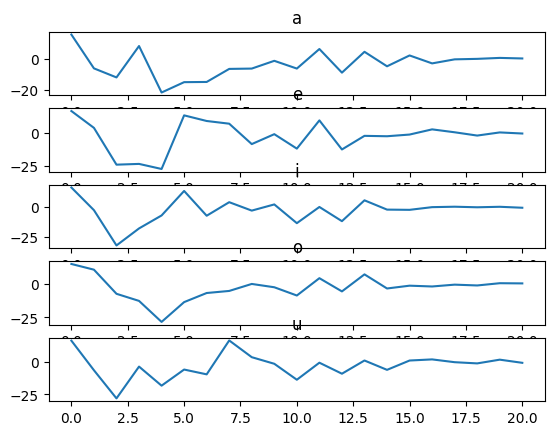

In [18]:
if __name__ == "__main__":
    main()